# Chong Zhen Jie A0201613Y
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from odeintw import odeintw

In [2]:
sns.set_theme(font_scale=1.5)
%load_ext memory_profiler

# Project Part IV: Question 4 using the MSA

In [3]:
# Set parameters
x0 = 1
v0 = 0
w0 = np.array([[x0], [v0]])

t0, t1 = 0, 1
t_list = np.linspace(t0, t1, 101)
t_list_rev = np.flip(t_list)

param = 1e-2 # value of lambda
R = np.array([[param]])
B = np.array([[0],[1]])
M = np.array([[1,0],[0,0]])

def compute_A(fn):
    return lambda t: np.array([[0.,1], [0,-fn(t)]])
fn1 = lambda t: np.sin(10*t)
fn2 = lambda t: t**2
A1 = compute_A(fn1)
A2 = compute_A(fn2)

# Define functions to compute the derivatives
def dwdt(w, t, A, u):
    # Retrieve corresponding u_t by indexing from the front
    return A(t)@w + B@u[int(t)*100]

def dpdt(p, t, A):
    return -A(t).T@p

def H_u(p, u):
    return B.T@p - 2*R*u

In [4]:
# Define function to run MSA algorithm
def MSA(A):
    # Initialize u; each entry u_t is in matrix form of size (1,1) for convenience
    u = np.array([[[-5]] for _ in range( len(t_list) )])
    
    # Fix learning rate
    eta = 7e-1
    
    # Initialize objective value
    val = np.inf
    
    # Record number of iterations
    count = 0
    
    # Main loop
    while 1:
        count += 1
        
        # Solve for w, integrating forward in time for t in [0,1]
        w = odeintw(dwdt, w0, t_list, args=(A, u))
        
        # Solve for p, integrating backward in time for t in [1,0]
        p = odeintw(dpdt, -2*M@w[-1], t_list_rev, args=(A,))
        
        # Update each entry by steepest ascent
        u = u + eta*(np.array([H_u(p_t,u_t) for p_t,u_t in zip(np.flip(p),u)]))
        
        # Stopping criterion
        val_new = w[-1][0]**2 + param*(np.linalg.norm(u)**2)
        if val_new < val:
            val = val_new
        else:
            break
        
    x, v = w[:, 0], w[:, 1]
    
    print(f"Solution reached at iteration {count}.")
    return x, v, p, u

In [5]:
# Run solver
x1, v1, p1, u1 = MSA(A1)
x2, v2, p2, u2 = MSA(A2)

Solution reached at iteration 27.
Solution reached at iteration 36.


In [6]:
# Check peak memory usage: around 125 MiB
# %memit MSA(A1)
# %memit MSA(A2)

In [7]:
# Check mean running time
# %timeit -r5 -n10 MSA(A1) # slightly under 100 ms
# %timeit -r5 -n10 MSA(A2) # around 50 ms

In [8]:
print(f"Estimated final position for sin(10t): {x1[-1][0]}")
print(f"Estimated final position for t^2: {x2[-1][0]}")

Estimated final position for sin(10t): 0.019862804036121194
Estimated final position for t^2: 0.021544376741219257


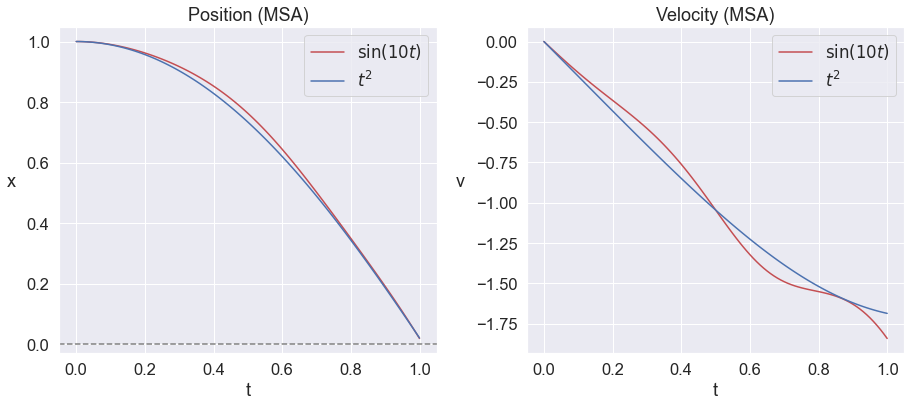

In [9]:
# Plot results for x and v over t_list
plt.figure(figsize=(13,6), tight_layout=True)

def plot_custom(input1, input2, ylabel, title):
    plt.plot(t_list, input1, label="$\sin(10t)$", c="r")
    plt.plot(t_list, input2, label="$t^2$", c="b")
    plt.xlabel("t")
    plt.ylabel(ylabel, rotation="horizontal", labelpad=15)
    plt.title(title)
    plt.legend()
    
plt.subplot(1,2,1)
plot_custom(x1, x2, "x", "Position (MSA)")
# Reference line
plt.axhline(0, ls="--", c="grey")

plt.subplot(1,2,2)
plot_custom(v1, v2, "v", "Velocity (MSA)")

plt.show()

### Convergence of the MSA method

In [10]:
# Modify function to run for 100 iterations
def MSA(A):
    u = np.array([[[-5]] for _ in range( len(t_list) )])
    eta = 7e-1
    val_list = []
    
    # Fixed at 100 iterations
    for _ in range(100):
        w = odeintw(dwdt, w0, t_list, args=(A, u))
        p = odeintw(dpdt, -2*M@w[-1], t_list_rev, args=(A,))
        u = u + eta*(np.array([H_u(p_t,u_t) for p_t,u_t in zip(np.flip(p),u)]))
    
        # Record changes in objective value over time
        val_new = w[-1][0]**2 + param*(np.linalg.norm(u)**2)
        val_list.append(val_new)
        
    return val_list

In [11]:
# Run solver for 100 iterations
val1 = MSA(A1)
val2 = MSA(A2)

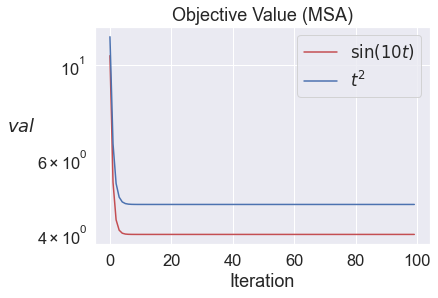

In [12]:
# Plot changes in objective value
plt.plot(range(100), val1, label="$\sin(10t)$", c="r")
plt.plot(range(100), val2, label="$t^2$", c="b")
plt.xlabel("Iteration")
plt.ylabel("$val$", rotation="horizontal", labelpad=15)
plt.yscale("log")
plt.title("Objective Value (MSA)")
plt.legend()

plt.show()

---